In [ ]:
%%capture
%%bash

apt install -y libboost-all-dev
pip install -U pip
pip install "pybind11[global]"

pip install aijack

In [ ]:
import os
import copy
import random

import kagglehub

import numpy as np
import pandas as pd

from aijack.attack import Poison_attack_sklearn

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

ModuleNotFoundError: No module named 'aijack'

In [ ]:
random.seed(42)


*Загрузим* данные

In [ ]:
path = kagglehub.dataset_download("dhoogla/distrinetcicids2017")
print("Path to dataset files:", path)

100%|██████████| 218M/218M [00:02<00:00, 83.3MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5


In [ ]:
dfps = []

for dirname, _, filenames in os.walk('/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5'):
    for filename in filenames:
        if filename.endswith('.parquet'):
            dfp = os.path.join(dirname, filename)
            dfps.append(dfp)
            print(dfp)

/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/DoS-Wednesday.parquet
/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/Benign-Monday.parquet
/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/Bruteforce-Tuesday.parquet
/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/Portscan-DDos-Botnet-Friday.parquet
/root/.cache/kagglehub/datasets/dhoogla/distrinetcicids2017/versions/5/Infiltration-Webattacks-Thursday.parquet


In [ ]:
dfps = [dfp for dfp in dfps if not 'Benign' in dfp]

In [ ]:
df = pd.concat([pd.read_parquet(dfp) for dfp in dfps], ignore_index=True)
df.shape

(1436640, 83)

Датасет предназначен для задачи многоклассовой классификации, но мы упростим ее и сведем к бинарной - бинарная классификация на нормальный и аномальный трафик.

In [ ]:
target = 'Label'

df[target] = df[target].replace('Attempted-relabel-as-Benign', 'Benign')
df.Label.value_counts() # benign - хороший трафик, остальное - нет

,count
Label,
Benign,1154753
DoS Hulk,158449
DDoS,95144
DoS GoldenEye,7567
Infiltration - Portscan,5485
DoS Slowloris,3998
FTP-Patator,3972
SSH-Patator,2961
DoS Slowhttptest,1741


In [ ]:
df.loc[df['Label'] != 'Benign', 'Label'] = 1
df.loc[df['Label'] == 'Benign', 'Label'] = 0

df['Label'] = df['Label'].astype(dtype=np.int32)

df['Label'].value_counts(normalize=True)

,proportion
Label,
0,0.803787
1,0.196213


### Train-test split

Для ускорения обучения моделей используем лишь часть данных

In [ ]:
X, X_test, y, y_test = train_test_split(
    df.drop(columns=['Label']),
    df['Label'],
    test_size=0.01,
    random_state=42,
)
X, X_train, y, y_train = train_test_split(
    X,
    y,
    test_size=0.05,
    random_state=42,
)
X_train.shape, X_test.shape

((71114, 82), (14367, 82))

### Constant Baseline

Константный бейзлайн в виде самого частотного класса предсказуемо не показывает хорошего качества

In [ ]:
roc_auc_score(y_true=y_test, y_score=[0.0]*len(y_test))

0.5

### SVM

Метод опорных векторов, напротив, демонстрирует хорошую производительность...

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
model = SVC(kernel="linear", C=1, random_state=42)

model.fit(X_train_scaled, y_train)
y_pred = model.predict(X_test_scaled)
roc_auc_score(y_true=y_test, y_score=y_pred)

0.987068040285753

#### SVC Interpretation

Давайте выясним, почему эта модель так хорошо работает.

Интерпретируйте работу обученной SVC-модели в ячейке ниже, для этого создайте bar-plot с визуализацией весов модели.

Hint: метод опорных векторов является линейной моделью, поэтому его интерпретация мало чем отличается от интерпретации линейной регрессии

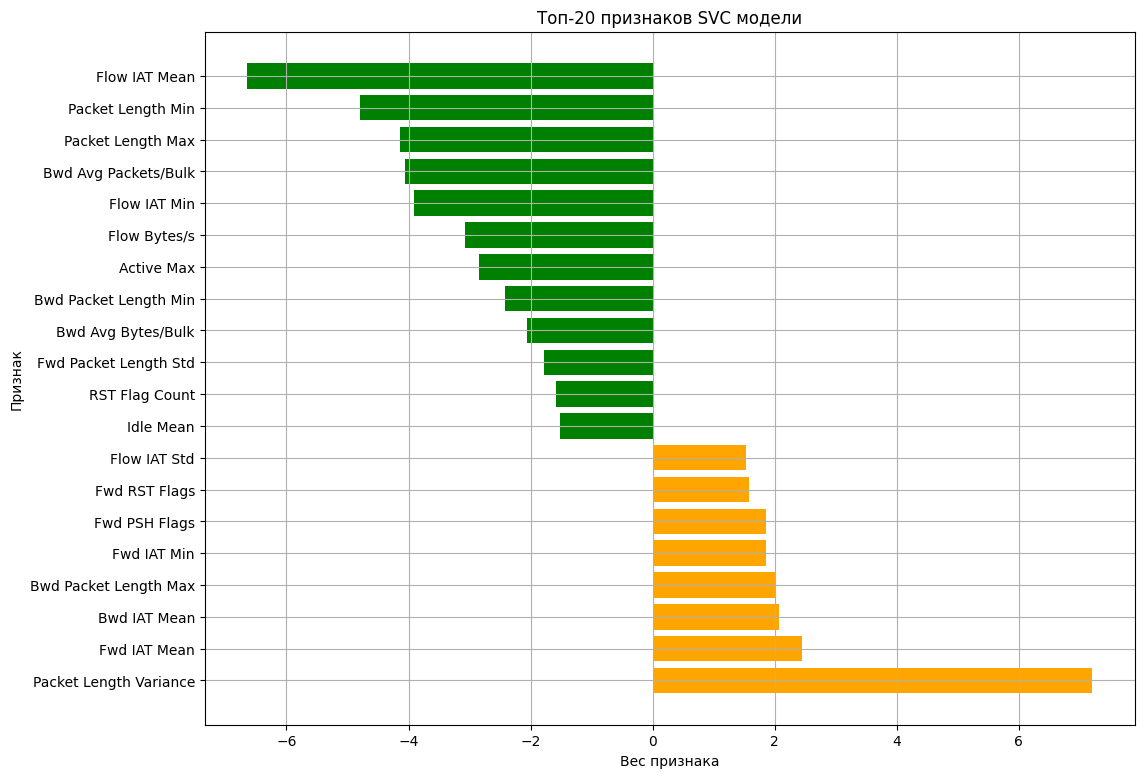

In [ ]:
import matplotlib.pyplot as plt

# Получаем веса модели
weights = model.coef_[0]

# Получаем индексы топ-20 весов по модулю
top_20_indices = np.argsort(np.abs(weights))[-20:]

# Создаем датафрейм с топ-20 весов
top_20_weights_df = pd.DataFrame({
    'Feature': X_train.columns[top_20_indices],
    'Weight': weights[top_20_indices]
})

# Сортируем датафрейм по весу
top_20_weights_df = top_20_weights_df.sort_values(by='Weight', ascending=False)

# Даем цвета весам
top_20_weights_df['Color'] = np.where(top_20_weights_df['Weight'] > 0, 'orange', 'green')

# Строим bar-plot
plt.figure(figsize=(12, 9))
plt.barh(range(20), top_20_weights_df['Weight'], color=top_20_weights_df['Color'])
plt.xlabel('Вес признака')
plt.ylabel('Признак')
plt.title('Топ-20 признаков SVC модели')
plt.yticks(range(20), top_20_weights_df['Feature'])
plt.grid(axis='x')
plt.grid(axis='y')
plt.show()

#### SVC Attack - Data poison

Выберем объект, который будем "отравлять"

In [ ]:
# initial point
initial_idx = 11
xc = copy.deepcopy(X_train_scaled[initial_idx, :])
yc = y_train.iloc[initial_idx]

Создадим небольшие train/test подвыборки для ускорения процесса обучения

In [ ]:
train_idx = random.sample(list(range(1, X_train_scaled.shape[0])), 500)
X_train_ = copy.copy(X_train_scaled[train_idx, :])
y_train_ = copy.copy(y_train.iloc[train_idx]).values

In [ ]:
test_idx = random.sample(list(range(1, X_test_scaled.shape[0])), 500)
X_test_ = copy.copy(X_test_scaled[test_idx, :])
y_test_ = copy.copy(y_test.iloc[test_idx]).values

aijack ожидает, что метки классов будут иметь вид 1/-1

In [ ]:
y_train_ = np.where(y_train_ == 1, 1, -1)
y_test_ = np.where(y_test_ == 1, 1, -1)

Создайте attacker и "отравленный" объект

In [ ]:
attacker = Poison_attack_sklearn(model, X_train_, y_train_, t=0.4)
xc_attacked, log = attacker.attack(xc, 1, X_test_, y_test_, num_iterations=100)

Посмотрим, насколько будет падать качество классификации до и после добавления "отравленного" объекта в модель

In [ ]:
clf = SVC(kernel="linear", C=1, random_state=42)
clf.fit(X_train_, y_train_)
print("before attack: ", roc_auc_score(y_true=y_test_, y_score=clf.predict(X_test_)))

# add poinsoned data
clf = SVC(kernel="linear", C=1, random_state=42)
clf.fit(
    np.concatenate([X_train_, xc_attacked.reshape(1, -1)]),
    np.concatenate([y_train_, [-1]]),
)

assert roc_auc_score(y_true=y_test_, y_score=clf.predict(X_test_)) < 0.9769
print("after attack: ", roc_auc_score(y_true=y_test_, y_score=clf.predict(X_test_)))

before attack:  0.9597902097902098
after attack:  0.9597902097902098


### Random Forest

Обучите модель случайного леса для решения задачи

In [ ]:
%%time

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
roc_auc_score(y_true=y_test, y_score=rf.predict(X_test))

CPU times: user 28.8 s, sys: 1.17 ms, total: 28.8 s
Wall time: 39.2 s


0.997707335446204

#### Random Forest Interpretation

Интерпретируйте предсказания случайного леса
- с использованием `permutation_importance`
- с использованием `shap`
- с использованием `lime` для двух любых объектов - с метками 0 и 1

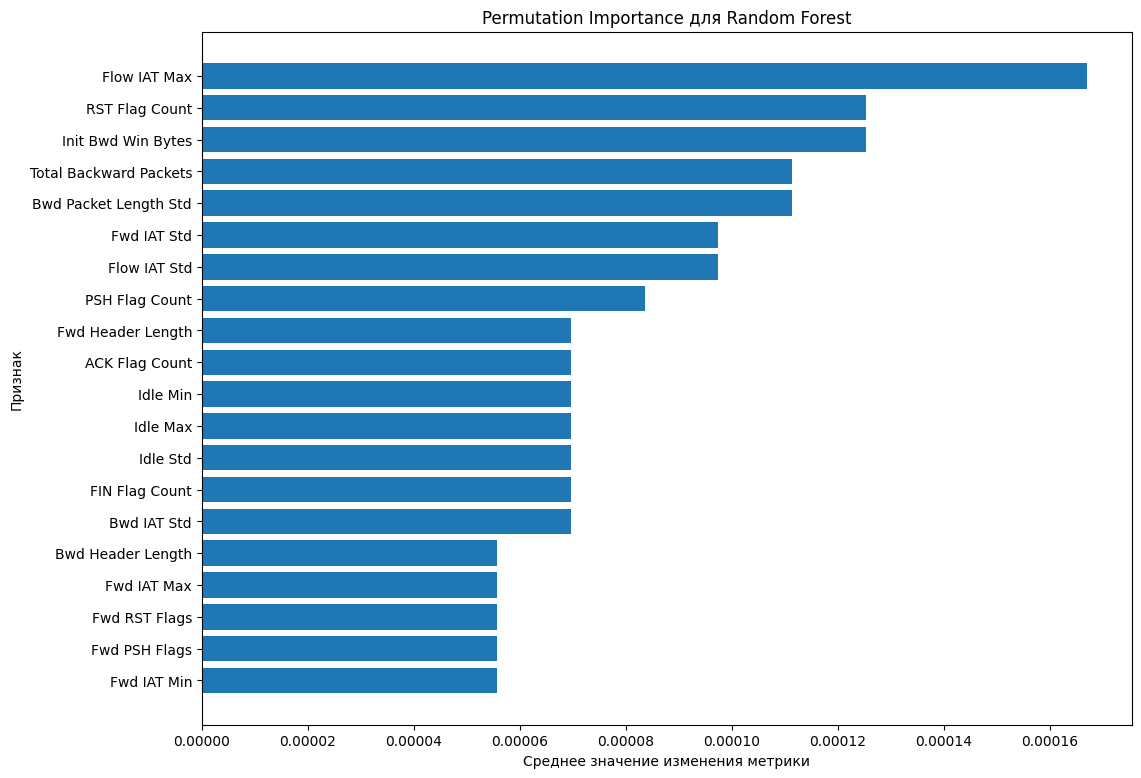

In [ ]:
from sklearn.inspection import permutation_importance

perm_importance = permutation_importance(rf, X_test, y_test, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

# Бар-диаграмма важности признаков
plt.figure(figsize=(12, 9))
plt.barh(X_train.columns[sorted_idx][-20:], perm_importance.importances_mean[sorted_idx][-20:])
plt.xlabel("Среднее значение изменения метрики")
plt.ylabel("Признак")
plt.title("Permutation Importance для Random Forest")
plt.show()

In [ ]:
!pip install shap

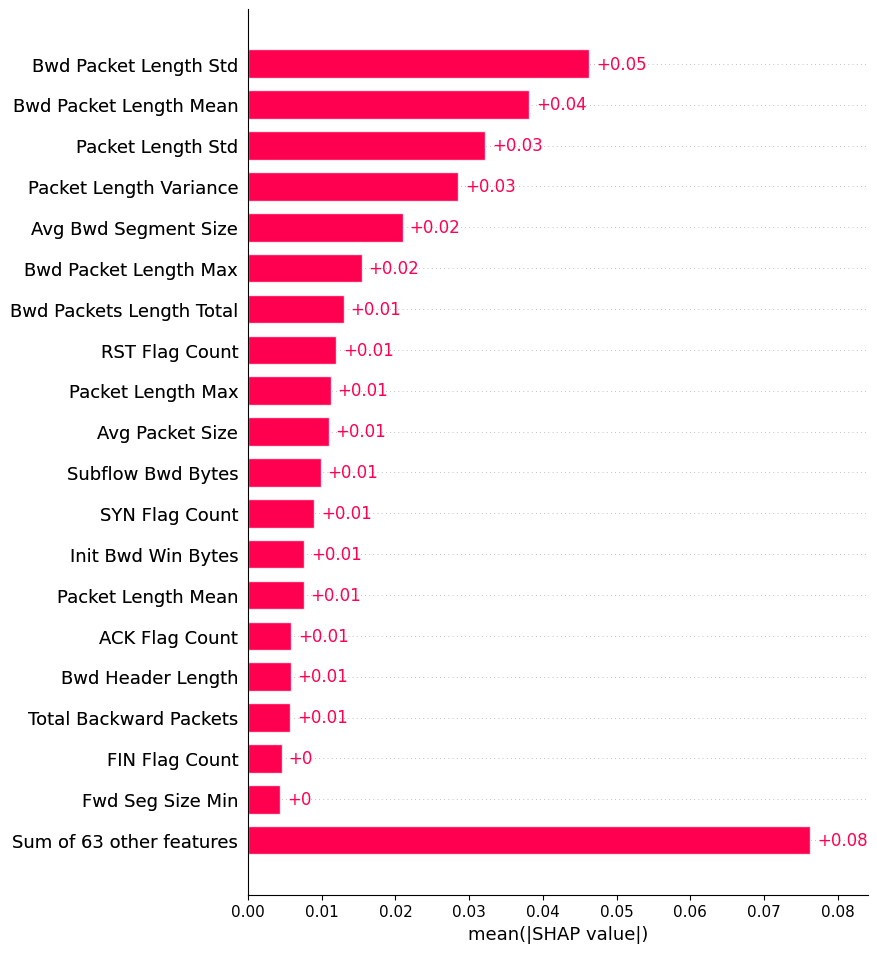

In [ ]:
import shap

# Вычисление значений SHAP
explainer = shap.Explainer(rf)
shap_values = explainer(X_test)

# SHAP значения для класса 0
shap_values_class0 = shap_values[..., 0]

# Построение бар-графика для класса 0
shap.plots.bar(shap_values_class0, max_display=20)